relaxation3qubitcode.py extends our previously developed simulation for the three-qubit bit flip code. In this version, we import all the original functions but gates now include relaxation errors.

In [1]:
from relaxation3qubitcode import * #Import previously defined functions - see basic 3 qubit code
import numpy as np
import time
import matplotlib.pyplot as plt

# 3-Qubit Bit Flip Code with Relaxation Errors

### Relaxation Errors 

We define relaxation errors through the following operators: 

$$
M_0 = \begin{bmatrix} 1 & 0 \\
                      0 & \sqrt{1-p} \end{bmatrix},
\quad
M_1 = \begin{bmatrix} 0 & \sqrt{p} \\
                      0 & 0 \end{bmatrix}.
$$

Again, where $p$ represents the probability of the qubit undergoing a relaxation error.

We can quickly see the effect of relaxation errors is different from bit flip errors. For example, consider a single qubit in a superposition state $a|0\rangle + b|1\rangle $. A bit flip error would transform this state into $b|0\rangle + a|1\rangle $, essentially swapping the amplitudes but keeping the qubit in a superposition state.

However, when the qubit undergoes a relaxation error

$$
M_1(a|0\rangle + b|1\rangle) = aM_1|0\rangle + bM_1|1\rangle = 0 + b|0\rangle = b|0\rangle,
$$

we are no longer in a superposition and we have tended towards classical behaviour (decoherance). 

We can also easily show how the density matrix will evolve,
$$
\rho \rightarrow \epsilon(\rho) = \sum_i M_i\rho M_i^\dagger =  \begin{bmatrix} \rho_{00} + p \rho_{11} & \sqrt{1-p} \rho_{01} \\
                                                                                    \sqrt{1-p} \rho_{10} & (1-p) \rho_{11} \end{bmatrix}
$$

Defining the relaxation time as $ T_1 $, then for a given gate time $ T_g $, the probability $ p_{T_1} $ that a qubit will undergo relaxation during this is:

$$ \large p_{relax} = 1 - e^{-\frac{T_g}{T_1}} $$

e.g. a faster decay for shorter $ T_1 $ times (or equivalently longer gate operations), which makes intuitive sense.


From this, we can define the function `relalxation_error`, which applies a relaxation error to each qubit (starting from the leftmost).

In [2]:
def relaxation_error(rho, T1, t):
    """
    Applies a relaxation error

    * rho: density matrix of the qubit system after a perfect gate operation
    * T1: the relaxation time of the qubits
    * t: length in time of the logical gate you are applying
    """

    num_qubits = int(np.log2(rho.shape[0]))
    
    # Calculate the probability of relaxation
    p_relax = 1 - np.exp(-t / T1)
    # p_relax = 0.05

    # Define relaxation
    m0 = np.array([[1, 0], [0, np.sqrt(1 - p_relax)]])
    m1 = np.array([[0, np.sqrt(p_relax)], [0, 0]])


    
    # Apply relaxation to each qubit, starting from the leftmost qubit (?)
    # new_rho = np.zeros_like(rho)
    for i in range(num_qubits):
        M0 = tensor_product(np.eye(2**i), m0, np.eye(2**(num_qubits - i - 1)))
        M1 = tensor_product(np.eye(2**i), m1, np.eye(2**(num_qubits - i - 1)))
        rho = M0 @ rho @ M0.T + M1 @ rho @ M1.T

    return rho

As the only gates we use in the 3 qubit code are CNOT gates, we just have to modify the CNOT gates to include the relaxation error. 

In [3]:
#Define a CNOT function with relaxation error:
def RE_fiveQCNOT(control, target, rho, T1 = 10, t = 0.2):
    """
    Applies a CNOT gate with relaxation error . 
    The function selects the appropriate CNOT gate based on specified control and target qubits, then applies a relaxation 
    error model to the resulting state.

    Args:
        control (int): Index of the control qubit (0 to 4).
        target (int): Index of the target qubit (0 to 4).
        rho (numpy.ndarray): The input density matrix representing the state of the 5-qubit system.
        T1: the relaxation time of the qubits
        t: length in time of the logical gate you are applying

    Returns:
        numpy.ndarray: The density matrix of the system after applying the CNOT gate and relaxation error.
        
    Note:
        This function assumes the availability of predefined CNOT gates for specific control-target pairs 
        in a 5-qubit system.
    """

    # Mapping control-target pairs to their CNOT gates
    cnot_gates = {
        (0, 1): CNOT_0_1,
        (1, 2): CNOT_1_2,
        (0, 3): CNOT_0_3,
        (1, 3): CNOT_1_3,
        (1, 4): CNOT_1_4,
        (2, 4): CNOT_2_4
    }

    # Select the appropriate CNOT gate based on control and target
    key = (control, target)
    if key in cnot_gates:
        rho = cnot_gates[key] @ rho @ cnot_gates[key].T
    else:
        return 'This CNOT is not available yet'

    #Apply relaxation error
    rho = relaxation_error(rho, T1, t)

    return rho


Now we want to analyze the system's behavior over time, considering each quantum gate operation as a single 'timestep'. Therefore, a complete cycle of our error correction process, is composed of 6 "timesteps"(4 "timesteps" for entangling ancilla qubits, 1 for measuring the ancilla qubits, and a (minimum) of 1 timestep for applying corrections). 

For our simulation parameters, we use a relaxation time $T_1 = 10 \mu s$, a gate time of $T_g = 0.2 \mu s$ (for both two qubit and single qubit gates). We calculate the fidelity of the quantum state after each cycle and do this for $n$ repetitions. We then compute the average fidelity across these repetitions after each error correction cycle. We can see current gate and $T_1$ times for IBM systems [here](https://quantum-computing.ibm.com/).

We generate a random state to encode by using `generate_random_state()`, which gives two random complex coefficients which we can use to create an arbitrary state to encode.


In [4]:
# Function to generate a random normalized quantum state
def generate_random_state():
    # Generate random complex numbers for a and b
    a = np.random.rand() + 1j * np.random.rand()
    b = np.random.rand() + 1j * np.random.rand()

    # Normalize the state
    norm_factor = np.sqrt(np.abs(a)**2 + np.abs(b)**2)
    a_normalized = a / norm_factor
    b_normalized = b / norm_factor

    return a_normalized, b_normalized

global a, b
a, b = generate_random_state()

In [5]:
from multiprocessing import Pool
def simulate_single_repetition(args):
    """
    Simulate a single repetition of the quantum error correction cycle with relaxation errors.
    Args:
    cycles (int): Number of error correction cycles to simulate.
    T1 (float): Relaxation time of the qubit in microseconds.
    Tg (float): Duration of each gate operation in microseconds.
    a (complex): Amplitude coefficient for the |0> state in the initial superposition.
    b (complex): Amplitude coefficient for the |1> state in the initial superposition.
    
    Returns:
    numpy.ndarray: An array of fidelity values for each cycle in this repetition.
    """

    cycles, T1, Tg, a, b = args
    fidelities = []

    #Create initial state
    initial_state = a * ket_0 + b * ket_1

    #Encode
    initial_density_matrix = state_to_density_matrix(initial_state)
    encoded_density = encode_logical_density_matrix(initial_density_matrix)

    # Create our 'ideal state'
    ideal_density = encoded_density
    
    # Calculate initial fidelity after encoding
    fidelities.append(1.0)

    for cycle in range(cycles):
        ancilla_added_density = rho_add_ancilla_qubits(encoded_density)
        result, rho_post = rho_measure_rightmost_2_qubits(ancilla_added_density)
        rho_post = relaxation_error(rho_post, T1=T1, t=Tg)
        corrected_density = rho_correct_density_matrix(rho_post, result)
        rho_post = relaxation_error(rho_post, T1=T1, t=Tg)
        reshaped_array = corrected_density.reshape([8, 4, 8, 4])
        final_density = np.einsum('jiki->jk', reshaped_array)
        # fidelity_value = np.real(fidelity(ideal_density_matrix, final_density))
        fidelity_value = np.real(fidelity(ideal_density, final_density))
        fidelities.append(fidelity_value)
        encoded_density = final_density

    return np.array(fidelities)

def logical_qubit_lifetime_simulation(cycles=500, repetitions=100, T1=10, Tg=0.2):
    """
    Simulate the lifetime of a logical qubit over multiple repetitions.
    
    Args:
    cycles (int): Number of cycles to simulate.
    repetitions (int): Number of repetitions for the simulation to average out random errors.
    T1 (float): Relaxation time of the qubit in microseconds.
    Tg (float): Duration of each gate operation in microseconds.
    
    Returns:
    tuple: A tuple containing the times at each cycle and the corresponding average fidelities.
    """
    # Generate a and b outside the function
    global a, b
    time_per_cycle = 6 * Tg
    times = np.arange(0, cycles * time_per_cycle + 1, time_per_cycle)
    args = [(cycles, T1, Tg, a, b) for _ in range(repetitions)]
    print(a,b)
    with Pool() as pool:
        results = pool.map(simulate_single_repetition, args)

    average_fidelities = np.mean(results, axis=0)
    return times, average_fidelities




We can also see how a single physical qubit decays overtime. This can be done by just applying the identity with relaxation errors at each time step (which is just a relaxation error at each timestep). If the physical qubit is in the state $|1\rangle$, we expect that at $T_1 = t$, the average fidelity will be $1/e$. We can verify this easily by conidering the action of $M$ at time $T_1 = t$:
$$
M|1\rangle = \sqrt{1-p_{\text{relax}}} |1\rangle + \sqrt{p_{\text{relax}}} |0\rangle = \sqrt{1/e}|1\rangle + \sqrt{1 - 1/e}|0\rangle
$$

As both states are pure,

$$ \text{Fidelity} = |\langle 1 | (\sqrt{1/e}|1\rangle + \sqrt{1 - 1/e}|0\rangle) |^2 = 1/e$$

We're effectively just leaving the physical qubit alone for the same length of time the error correction cycle occurs.

We can easily see this in action if we change the initial state to $|1\rangle$ in the `physical_qubit_lifetime_simulation` below. However, for the purpose of relaxation errors, we generate the same random state as above (however this time, no encoding!) via the coefficients a and b.

In [6]:
def physical_qubit_lifetime_simulation(cycles=500, T1=10, Tg=0.2):
    """
    Simulates the lifetime of a physical qubit under the influence of relaxation errors.
    This function evaluates how the fidelity of a single qubit evolves over a series of
    cycles, each including multiple gate operations, considering the qubit's T1 relaxation time.

    Parameters:
    cycles (int): Number of cycles to simulate.
    T1 (float): Relaxation time of the qubit in microseconds.
    Tg (float): Duration of each gate operation in microseconds.

    Returns:
    tuple: A tuple containing the times at each cycle and the corresponding average fidelities.
    """


    # Time per cycle in microseconds with 6 gate operations
    time_per_cycle = 6 * Tg
    
    average_fidelities = np.zeros(cycles + 1)  # Initialize average fidelities to zero
    times = np.arange(0, (cycles + 1) * time_per_cycle , time_per_cycle)  # Time for each cycle

    # Generate initial state
    global a, b

    initial_state = a * ket_0 + b * ket_1
    initial_density_matrix = state_to_density_matrix(initial_state)

    # Create ideal density matrix for fidelity calculations
    ideal_density_matrix = initial_density_matrix

    # Store initial fidelity
    fidelities = [1.0]  # Start with fidelity of 1 for the initial state

    for cycle in range(cycles):
        
        # Apply relaxation error (identity operation with relaxation)
        for i in range(6):
            rho = relaxation_error(initial_density_matrix, T1, 0.2) 
            initial_density_matrix = rho
            
        # Compute fidelity with the ideal initial state
        fidelity_value = np.real(fidelity(ideal_density_matrix, rho))
        fidelities.append(fidelity_value)

        # Update the density matrix for the next cycle
        initial_density_matrix = rho

    average_fidelities = np.array(fidelities)
    return times, average_fidelities


We can now compare the $T_1$ times for $|1\rangle$ and $|1\rangle_L$.

In [9]:
start_time = time.time()

# Data for logical qubit lifetime
times_logical, average_fidelities_logical = logical_qubit_lifetime_simulation(cycles=80, repetitions=1000)

end_time = time.time()
print(f"Execution Time: {end_time - start_time} seconds")

print("Time taken: ", end_time - start_time)
# Data for physical qubit lifetime
times_physical, average_fidelities_physical = physical_qubit_lifetime_simulation(cycles=80)

(0.24841514207361717+0.5399497151322082j) (0.4714353071983122+0.6515312528528656j)
Execution Time: 108.29778957366943 seconds
Time taken:  108.29778957366943


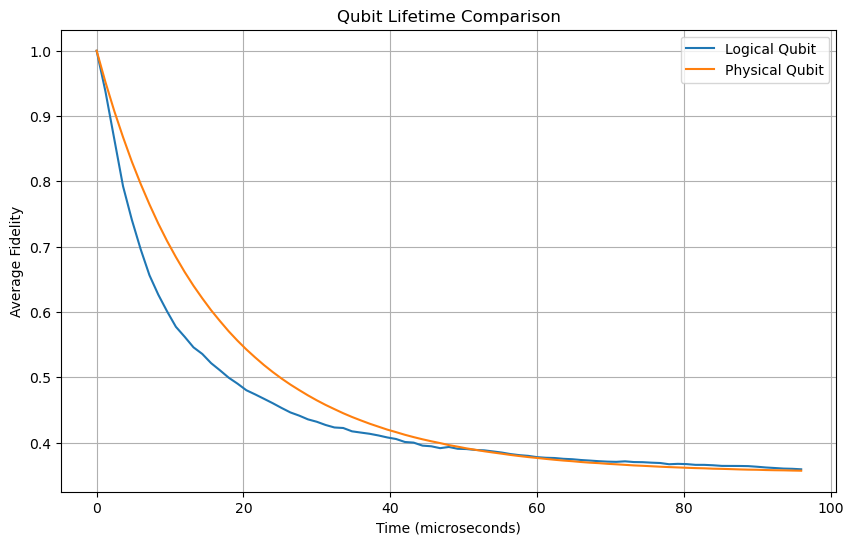

In [10]:
# Combined plot
plt.figure(figsize=(10, 6))
plt.plot(times_logical, average_fidelities_logical, linestyle='-', label='Logical Qubit')
plt.plot(times_physical, average_fidelities_physical, linestyle='-', label='Physical Qubit')

# Adding a horizontal line at 1/e
# plt.axhline(y=1/np.e, color='r', linestyle='--', label='1/e')

plt.title('Qubit Lifetime Comparison')
plt.xlabel('Time (microseconds)')
plt.ylabel('Average Fidelity')
plt.legend()
plt.grid(True)
plt.show()

#### Limitations:
- We only consider relaxation errors (not 'phase damping') or other forms of errors
- We consider two qubit gate times to be equal to single qubit gate times (in practice, two qubit gate times are slower)
- Assuming only 1 'timestep' for corrections
- All qubits are equally likely to undego relaxation errors
